In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from collections import Counter

from tqdm import tqdm
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# librairies a importer pour avoir les notion de date et de temps.
from datetime import datetime, date, time

# autre librairie importante à importer car elle contient un parser qui permet de detecter le format des strings de type date
# et les convertit automatiquement.
from dateutil.parser import parse

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

new_column_names = [
    'WikipediaMovieID',
    'FreebaseMovieID',
    'MovieName',
    'MovieReleaseDate',
    'MovieBoxOfficeRevenue',
    'MovieRuntime',
    'MovieLanguages',
    'MovieCountries',
    'MovieGenres'
]


df = pd.read_csv('dataset/cmu_merged_with_imdb.csv')


,IMDbID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,PlotSummaries,averageRating,genres,Category
0,tt0228333,Ghosts of Mars,2001,14010832.0,98.0,English,United States of America,"Set in the second half of the 22nd century, th...",4.9,"Action,Horror,Sci-Fi",Non Socio-Political
1,tt0097499,Henry V,1989,10161099.0,137.0,English,United Kingdom,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,7.5,"Biography,Drama,History",Non Socio-Political
2,tt0058331,Mary Poppins,1964,102272727.0,139.0,English,United States of America,The film opens with Mary Poppins perched in a...,7.8,"Comedy,Family,Fantasy",Socio-Political
3,tt0255819,Baby Boy,2001,29381649.0,123.0,English,United States of America,A young 20-year-old named Jody lives with his...,6.4,"Crime,Drama,Romance",Socio-Political
4,tt0367546,Bindiya Chamkegi,1984,NaN,NaN,Hindi,India,Shalini 'Shalu' lives a wealthy lifestyle with...,4.9,"Comedy,Family",Non Socio-Political
...,...,...,...,...,...,...,...,...,...,...,...
14945,tt0107057,Guilty as Sin,1993,22886222.0,107.0,None,United States of America,Jennifer Haines is an up-and-coming Chicago a...,5.7,"Crime,Drama,Thriller",Socio-Political
14946,tt0372937,Into the Mirror,2003,NaN,113.0,Korean,South Korea,After accidentally causing the death of his pa...,6.4,"Action,Fantasy,Horror",Non Socio-Political
14947,tt0109922,Gopi Kishan,1994,NaN,NaN,Hindi,India,Kishan killed a man in his childhood when the...,5.8,"Action,Comedy,Drama",Socio-Political
14948,tt0033660,The Ghost Train,1941,NaN,82.0,English,United Kingdom,{{plot}} The film opens with a Great Western e...,6.2,"Comedy,Horror",Socio-Political


In [13]:
# Analyse des differents themes.
df['War'] = df['PlotSummaries'].str.contains("War|war|Military conflict|military conflict|Armed conflict|armed conflict|Battle|battle|Combat|combat|Soldier|soldier|Veteran|veteran|Army|army|Navy|navy|Air Force|air force|Marine Corps|marine corps|Warzone|warzone|Battlefield|battlefield|Casualty|casualty|POW|pow|MIA|mia|Victory|victory|Defeat|defeat|Peacekeeping|peacekeeping|Atrocities|atrocities|Antiwar|antiwar|Nuclear war|nuclear war|Chemical warfare|chemical warfare|Biological warfare|biological warfare|Cyberwarfare|cyberwarfare|Guerrilla warfare|guerrilla warfare|Proxy war|proxy war|Armistice|armistice|Bombing|bombing|Front line|front line|Genocide|genocide|Invasion|invasion|Landmine|landmine|Tank|tank|Victory garden|victory garden|War crime|war crime|Aerial warfare|aerial warfare|Amphibious warfare|amphibious warfare|Artillery|artillery|Civil war|civil war|Covert operation|covert operation|Cyberattack|cyberattack|Firebombing|firebombing|Friendly fire|friendly fire|Gas attack|gas attack|Grenade|grenade|Infantry|infantry|Land warfare|land warfare|Machine gun|machine gun|Mercenary|mercenary|Missile|missile|Naval warfare|naval warfare|Nuclear weapon|nuclear weapon|Paratrooper|paratrooper|Radar|radar|Sniper|sniper|Submarine|submarine|Tank warfare|tank warfare|Trench warfare|trench warfare|War correspondent|war correspondent|War economy|war economy|War film|war film|War novel|war novel|War photography|war photography|War propaganda|war propaganda|War veteran|war veteran'")
df['Apartheid'] = ((df['PlotSummaries'].str.contains("apartheid|Apartheid|racial segregation|Racial segregation|racial discrimination|Racial discrimination")|((df['PlotSummaries'].str.contains('Racial|racial')) & (df['PlotSummaries'].str.contains('Segregation|segregation|discrimination|Discrimination')))))
df['Decolonisation'] = (df['PlotSummaries'].str.contains("decolonisation|Decolonisation")|(df['PlotSummaries'].str.contains("Country|country")&(df['PlotSummaries'].str.contains("Independence|independence"))))
df['Revolution_communism'] = (df['PlotSummaries'].str.contains('Revolution|revolution|Establishment|establishment|movement|Movement|socio-political movement|Socio-political movement')& df['PlotSummaries'].str.contains('Communism|communism|Communist government|communist government|communist|Communist'))|(df['PlotSummaries'].str.contains('Revolution|revolution|Establishment|establishment|movement|Movement|socio-political movement|Socio-political movement')&df['PlotSummaries'].str.contains('Russia|russian|Rusian|China|Chinese|chinese|Cuba|Cuban|cuban'))|(df['PlotSummaries'].str.contains('Staline|Lenine|Mao Zedong|Fidel Castro|Che Guevara'))
df['Cold_War'] = (df['PlotSummaries'].str.contains('Cold|cold')&df['PlotSummaries'].str.contains('War|war')& df['PlotSummaries'].str.contains('United Sate|USA|Western Bloc')& df['PlotSummaries'].str.contains('Soviet Union|Eastern Bloc'))|(df['PlotSummaries'].str.contains('East Berlin|West Berlin|Berlin Blockade|Korean war|korean war|Vietnam war|vietnamian war|Vietnamian war|Cuban Missile Crisis|Soviet–Afghan War|Nuclear weapon|nuclear weapon|atomic spies|Atomic spies| Manhattan Project|Cuban Revolution|Cuban Missile Crisis|Operation Mangoose|nuclear war|Nuclear war|Vietnam war|Sovietization'))
df['Women_rights'] = (df['PlotSummaries'].str.contains('Women|women') & df['PlotSummaries'].str.contains('Rights|rights'))|(df['PlotSummaries'].str.contains('gender')&df['PlotSummaries'].str.contains('discrimination|Discrimination|inequality|Inequality'))&(df['PlotSummaries'].str.contains('Women’s Liberation Movement'))
df['Berlin_Wall'] = ((df['PlotSummaries'].str.contains('Berlin')) & (df['PlotSummaries'].str.contains('Wall|wall'))&(df['PlotSummaries'].str.contains('Fall|fall'))&(df['PlotSummaries'].str.contains('East Berlin|West Berlin')))
df['Space_Race'] = ((df['PlotSummaries'].str.contains('Space|space')) & (df['PlotSummaries'].str.contains('Race|race')))
df['Soviet_Union_Disolution'] = ((df['PlotSummaries'].str.contains('Soviet|soviet')) & (df['PlotSummaries'].str.contains('Union|union'))& (df['PlotSummaries'].str.contains('Dissolution|dissolution')))
df['Civil_right_racial_segregation'] = ((df['PlotSummaries'].str.contains('Civil|civil')) & (df['PlotSummaries'].str.contains('Rights|rights')) |( (df['PlotSummaries'].str.contains('Racial|racial')) & (df['PlotSummaries'].str.contains('Segregation|segregation|Discrimination|discrimination'))))
df['Economic hardship, struggle for survival'] = ((df['PlotSummaries'].str.contains('Economic|economic|Economical|economical')) & (df['PlotSummaries'].str.contains('Hardship|hardship|Crisis|crisis|downturn|Downturn|Depression|depression|bankroot|Bankroot|Struggle|struggle|Survival|survival'))) 



In [14]:
themes = ['War','Apartheid','Decolonisation','Revolution_communism','Cold_War', 'Women_rights','China_revolution','Berlin_Wall','Space_Race','Soviet_Union_Disolution','Civil_right_racial_segregation','Economic hardship, struggle for survival']
years = np.arange(0,110,10)
years = years + 1900
print(years)

[1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000]


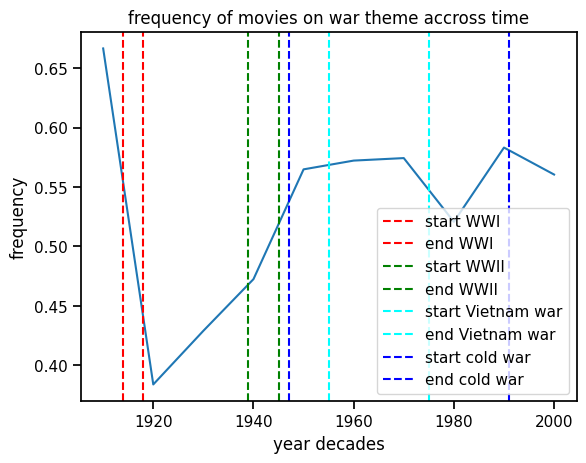

In [15]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[0]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on war theme accross time')
plt.axvline(x=1914, color='red', linestyle='--', label='start WWI')
plt.axvline(x=1918, color='red', linestyle='--', label='end WWI')
plt.axvline(x=1939, color='green', linestyle='--', label='start WWII')
plt.axvline(x=1945, color='green', linestyle='--', label='end WWII')
plt.axvline(x=1955, color='cyan', linestyle='--', label='start Vietnam war')
plt.axvline(x=1975, color='cyan', linestyle='--', label='end Vietnam war')
plt.axvline(x=1947, color='blue', linestyle='--', label='start cold war')
plt.axvline(x=1991, color='blue', linestyle='--', label='end cold war')
plt.xlabel('year decades')
plt.ylabel('frequency')
plt.legend()
plt.show()


We can see that the frequency of movies about war themes decrease during wrold war I and then start to increase after its' end and remain very popular during all other war events as world war II, the cold war or Vietnam war. The decrease during world war I can be explained by the way that at the begining the cinema was very developped and needed important ressources to produces films. During world war I these ressources decreased and thus the general frequency of film with them. After the world war I progress in technologies allowed to produce films more easily allowing a  more important film production and as the war become more and more popular and mind occupieng theme in decades following world war I due to historical event perfectly explain the increase of the frequency of films about war theme.

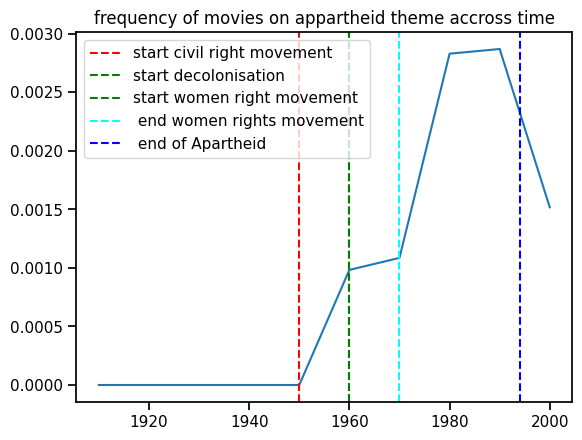

In [16]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[1]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on appartheid theme accross time')
plt.axvline(x=1950, color='red', linestyle='--', label='start civil right movement')
plt.axvline(x=1960, color='green', linestyle='--', label='start decolonisation ')
plt.axvline(x=1960, color='green', linestyle='--', label='start women right movement')
plt.axvline(x=1970, color='cyan', linestyle='--', label=' end women rights movement')
plt.axvline(x=1994, color='blue', linestyle='--', label=' end of Apartheid')
plt.legend()
plt.show()

We see that before 1950, so the start of civil right movement there is no film on topic of apartheid or racial discrimination.
We see these film start to appear after the start of the civil right movement and undergo a first increase. A second increase more important is observed sa certain period after the begining of decolonisation and the women civil right movement. By this image it become clear that these topic was probably censured at the beginning by government, political events as civil right movement and decolonisation leaded to a progressive emancipation of movies from the censura and apparition of films on this topic.

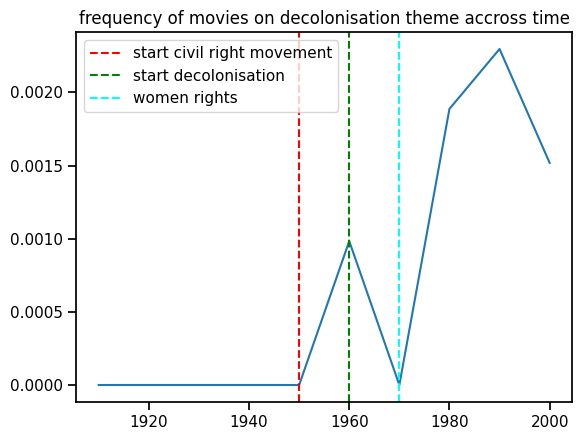

In [17]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[2]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on decolonisation theme accross time')
plt.axvline(x=1950, color='red', linestyle='--', label='start civil right movement')
plt.axvline(x=1960, color='green', linestyle='--', label='start decolonisation')
plt.axvline(x=1970, color='cyan', linestyle='--', label='women rights')
plt.legend()
plt.show()

Here we see that also the theme of women right was absent from movies before 1940 and begin appear and increase only a small interval of time before the starting of civil right movement reflection the cultural atmosphera of peoples thinking about human inqualities and that probably contributed to trigger this movement. The second pic occur definitively after the beginning of women right womemen that make popular the theme of women rights.

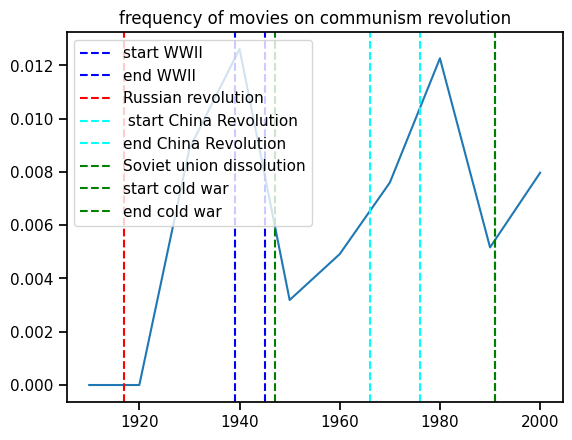

In [18]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[3]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on communism revolution')
plt.axvline(x=1939, color='blue', linestyle='--', label='start WWII')
plt.axvline(x=1945, color='blue', linestyle='--', label='end WWII')
plt.axvline(x=1917, color='red', linestyle='--', label='Russian revolution')
plt.axvline(x=1966, color='cyan', linestyle='--', label=' start China Revolution')
plt.axvline(x=1976, color='cyan', linestyle='--', label='end China Revolution')
plt.axvline(x=1991, color='green', linestyle='--', label='Soviet union dissolution')
plt.axvline(x=1947, color='green', linestyle='--', label='start cold war')
plt.axvline(x=1991, color='green', linestyle='--', label='end cold war')
plt.legend()
plt.show()

We can see that the film about communist revolution start to appear after 1917 that is the october revolution and their frequency increase untile the begining of the second wold war. This is explained by the fact that the communist revolution become a key topic in the culture of slavic countries. The decrease of frequence during world war two as we can see it is perfectly expected as the ressource available for making film are limited during such period. The the frequency of film about communist revolution increase highly as the interest for this topic increase accross time du to historical events as cold war, china revolution, Vietnam War, Soviet Union dissolution.

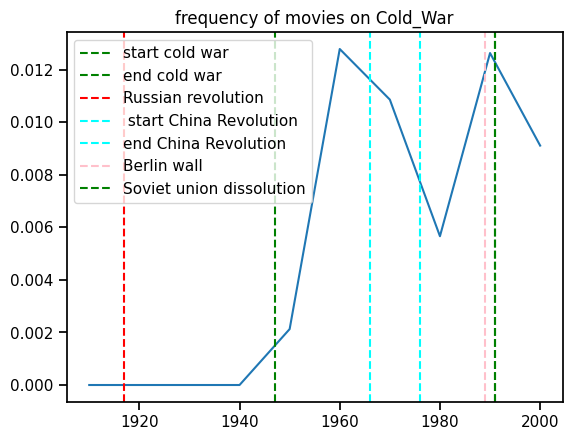

In [19]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[4]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on Cold_War')
plt.axvline(x=1947, color='green', linestyle='--', label='start cold war')
plt.axvline(x=1991, color='green', linestyle='--', label='end cold war')
plt.axvline(x=1917, color='red', linestyle='--', label='Russian revolution')
plt.axvline(x=1966, color='cyan', linestyle='--', label=' start China Revolution')
plt.axvline(x=1976, color='cyan', linestyle='--', label='end China Revolution')
plt.axvline(x=1989, color='pink', linestyle='--', label='Berlin wall')
plt.axvline(x=1991, color='green', linestyle='--', label='Soviet union dissolution')
plt.legend()
plt.show()

It can be seen that there is no topic about cold war topic before the starting of the cold war which is logical and the frequency start to increase at the beginin of the cold war and until it end as this theme was a center is the field of cultural and political interest. After the dissolution of soviet union this theme loose in importance and interest explaining the drop of frequencies of films about this theme.

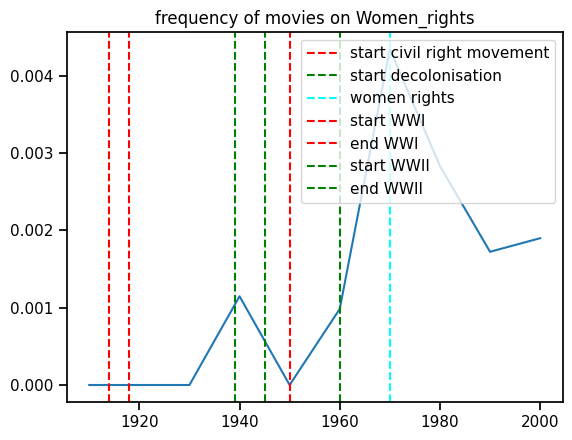

In [20]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[5]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on Women_rights')
plt.axvline(x=1950, color='red', linestyle='--', label='start civil right movement')
plt.axvline(x=1960, color='green', linestyle='--', label='start decolonisation')
plt.axvline(x=1970, color='cyan', linestyle='--', label='women rights')
plt.axvline(x=1914, color='red', linestyle='--', label='start WWI')
plt.axvline(x=1918, color='red', linestyle='--', label='end WWI')
plt.axvline(x=1939, color='green', linestyle='--', label='start WWII')
plt.axvline(x=1945, color='green', linestyle='--', label='end WWII')
plt.legend()
plt.show()

We see that the interest for the them of civil right of women undergo a pic during inter war period between word war I and II
The interest was lost during world war II but then start again during the women civil right movement and remain popular until today.

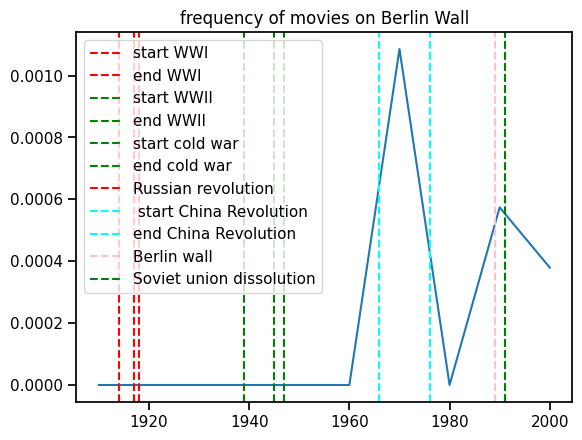

In [21]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[7]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on Berlin Wall')
plt.axvline(x=1914, color='red', linestyle='--', label='start WWI')
plt.axvline(x=1918, color='red', linestyle='--', label='end WWI')
plt.axvline(x=1939, color='green', linestyle='--', label='start WWII')
plt.axvline(x=1945, color='green', linestyle='--', label='end WWII')
plt.axvline(x=1947, color='green', linestyle='--', label='start cold war')
plt.axvline(x=1991, color='green', linestyle='--', label='end cold war')
plt.axvline(x=1917, color='red', linestyle='--', label='Russian revolution')
plt.axvline(x=1966, color='cyan', linestyle='--', label=' start China Revolution')
plt.axvline(x=1976, color='cyan', linestyle='--', label='end China Revolution')
plt.axvline(x=1989, color='pink', linestyle='--', label='Berlin wall')
plt.axvline(x=1991, color='green', linestyle='--', label='Soviet union dissolution')
plt.legend()
plt.show()

 we see that the frequency of the Berlin wall fall topic occured some decade before the historical evenement showing that during cold war intellectual speculation were present about such issue seeing the end of the cold war approaching. This idea were incarnated in film and were present in the interest of peoples.

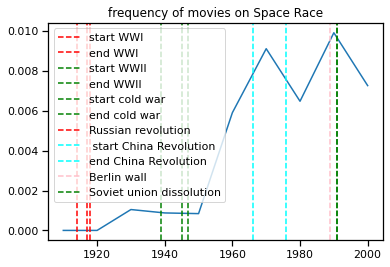

In [39]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[8]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on Space Race')
plt.axvline(x=1914, color='red', linestyle='--', label='start WWI')
plt.axvline(x=1918, color='red', linestyle='--', label='end WWI')
plt.axvline(x=1939, color='green', linestyle='--', label='start WWII')
plt.axvline(x=1945, color='green', linestyle='--', label='end WWII')
plt.axvline(x=1947, color='green', linestyle='--', label='start cold war')
plt.axvline(x=1991, color='green', linestyle='--', label='end cold war')
plt.axvline(x=1917, color='red', linestyle='--', label='Russian revolution')
plt.axvline(x=1966, color='cyan', linestyle='--', label=' start China Revolution')
plt.axvline(x=1976, color='cyan', linestyle='--', label='end China Revolution')
plt.axvline(x=1989, color='pink', linestyle='--', label='Berlin wall')
plt.axvline(x=1991, color='green', linestyle='--', label='Soviet union dissolution')
plt.legend()
plt.show()

The interest for space race occur during the period of the end of world war I and II probably in this case the interest was for the space race between lands of Allies and Axes for exemple concerning nuclear weapon. But the frequence of film grew up significantly in the context of cold war where society was interested in space Race between the Western and the Eastern Bloc. Interest and with it frequency of film about this theme start to decrease after the end of soviet union which match to what is expected.

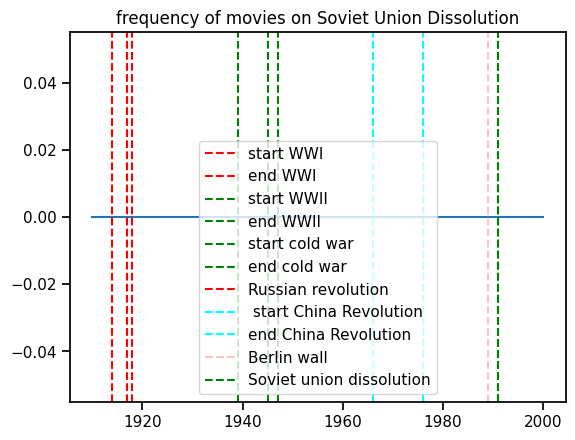

In [22]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[9]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on Soviet Union Dissolution')
plt.axvline(x=1914, color='red', linestyle='--', label='start WWI')
plt.axvline(x=1918, color='red', linestyle='--', label='end WWI')
plt.axvline(x=1939, color='green', linestyle='--', label='start WWII')
plt.axvline(x=1945, color='green', linestyle='--', label='end WWII')
plt.axvline(x=1947, color='green', linestyle='--', label='start cold war')
plt.axvline(x=1991, color='green', linestyle='--', label='end cold war')
plt.axvline(x=1917, color='red', linestyle='--', label='Russian revolution')
plt.axvline(x=1966, color='cyan', linestyle='--', label=' start China Revolution')
plt.axvline(x=1976, color='cyan', linestyle='--', label='end China Revolution')
plt.axvline(x=1989, color='pink', linestyle='--', label='Berlin wall')
plt.axvline(x=1991, color='green', linestyle='--', label='Soviet union dissolution')
plt.legend()
plt.show()

The frequency of film about soviet union dissolution begin after 1990 which globaly match to the end of soviet union so this is logic.

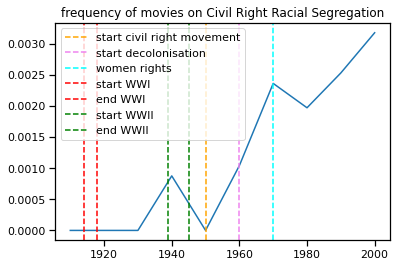

In [19]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[10]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on Civil Right Racial Segregation')
plt.axvline(x=1950, color='orange', linestyle='--', label='start civil right movement')
plt.axvline(x=1960, color='violet', linestyle='--', label='start decolonisation')
plt.axvline(x=1970, color='cyan', linestyle='--', label='women rights')
plt.axvline(x=1914, color='red', linestyle='--', label='start WWI')
plt.axvline(x=1918, color='red', linestyle='--', label='end WWI')
plt.axvline(x=1939, color='green', linestyle='--', label='start WWII')
plt.axvline(x=1945, color='green', linestyle='--', label='end WWII')
plt.legend()
plt.show()

The frequence of film about civil right and racial segregation become a little bit non nul between the two world wars and then start to significantly grow up after the civil right movement and accros such events as the begining of decolonisation and women civil right movements.

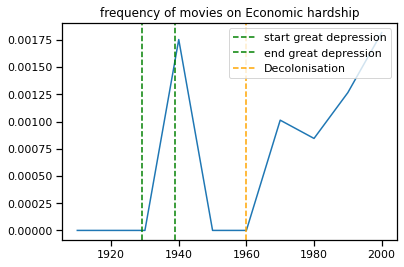

In [27]:
f = []
for i in range(0,len(years)-1):
    a = years[i]
    b = years[i+1]
    data = df[(df['MovieReleaseDate'] >= a) & (df['MovieReleaseDate'] <= b)]
    decade_frequency = len(data[data[themes[11]] == True])/len(data)
    f.append(decade_frequency)
plt.plot(years[1:],f)
plt.title('frequency of movies on Economic hardship')
plt.axvline(x=1929, color='green', linestyle='--', label='start great depression')
plt.axvline(x=1939, color='green', linestyle='--', label='end great depression')
plt.axvline(x=1960, color='orange', linestyle='--', label='Decolonisation')
plt.legend()
plt.show()

Two important things can be seen. First we see that the frequency of film about economic crisis topics increase especialy firstly at the moment of the great depression and then after the beginning of decolonisation.